## Outline the Machine Learning model
This workflow exemplfies the proceedure to make a simple hydrological machine learning model using remote sensing data products available through Google Earth Engine. 

![ML_workflow.JPG](./Images/ML_workflow.JPG)

In this chapter we will:

1. Select a prediction location based on in situ USGS National Water Information Systems (NWIS) data availability
2. Connect to Google Earth Engine and select applicable hydrometeorological features for input into a model
3. Create a normalized dataframe to train a machine learning model

## Find a Streamflow Prediction location

Go to the [USGS National Water Information System: Mapper](https://maps.waterdata.usgs.gov/mapper/index.html) and find a surface water monitoring location with ample record (>10 years).

Lets look at USGS site 10172200 Red Butte Creek at Fort Douglass, Near SLC, UT

![USGS_10172200](./Images/USGS_1017200_Red_Butte.JPG)

We can see there is a long-term record existing from 1986 to present, the site records discharge (cfs) and water quality parameters (temperature, specific conductance).

Lets use Python to get the data!

In [1]:
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
import pandas as pd
import numpy as np

def NWIS_retrieve(site, startDT, endDT):
    service = IVDataService()
    usgs_data = service.get(
        sites=site,
        startDT= startDT,
        endDT= endDT
        )
    return usgs_data       

In [140]:
start = '2020-1-1'
end = '2022-12-31'
NWISid = '10172200'

flow = NWIS_retrieve(NWISid, start, end)

#make the date the index for plotting and resampling
flow['datetime'] = flow['value_time']
flow.set_index('datetime', inplace = True)

#clean the data
flow = flow[flow['value'] > 0]

## Dataframe check
Lets explore the data:

1. What is the temporal resolution?
2. What are the dataframe headers/columns?
3. What variable are we seeing and in what units?
4. How many observations are there?

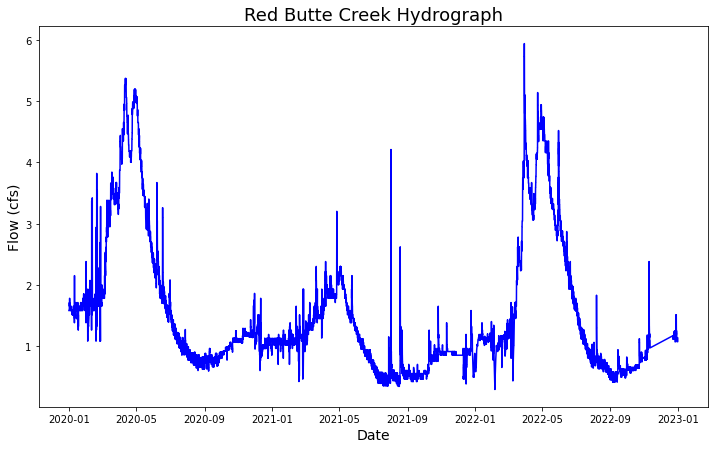

In [137]:
# Subplots.
fig, ax = plt.subplots(1,1, figsize=(12, 7))
fig.patch.set_facecolor('white')

#set min/max for y-axis
#y-axis
ymin = min(flow['value'])*1.1
ymax = max(flow['value'])*1.1

#set colors
color_f = 'blue'


# Add flow to plot.
ax.plot(flow.index, flow['value'],
           c=color_f, label='Flow (cfs)')
ax.set_ylabel('Flow (cfs)', fontsize = 14)
ax.set_xlabel('Date',  fontsize = 14)
ax.set_title('Red Butte Creek Hydrograph', fontsize = 18)

plt.show()

In [ ]:
# Add some parameters.
ax.set_title('Temperature and Precipitation for Red Butte Creek', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [$^\circ$F]', fontsize=14, color = color_t)
ax.tick_params(axis='y', labelcolor=color_t)
ax.set_ylim(ymin, ymax)

#add freezing pt horizontal line
ax.hlines(y=32, xmin=min(temp_RB['datetime']), xmax=max(temp_RB['datetime']), linewidth=1, color='darkblue')
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper left')

#add a second y-axis to show the precipitation
ax2 = ax.twinx()
ax2.set_ylabel('Precipitation (in)', color=color_p)  # we already handled the x-label with ax1

#add the precipitation scatter plot
ax2.scatter(precip_RB['datetime'], precip_RB['precipitation_in'],
           c=color_p, alpha=0.35, label='Precipitation (in)')

#Add a fitted Precipition line
ax2.plot(precip_RB['datetime'],
        fit_func(x_data_p, params_p[0], params_p[1], params_p[2], params_p[3]),
        label='Precipitation (fitted)', color=color_p, lw=2.5)

ax2.tick_params(axis='y', labelcolor=color_p)
ax2.legend(fontsize=14, loc='upper right')


## Catchment Characteristics
Streamflow is highly correlated to the underlying catchment characteristics, such as:
1. Area
2. Elevation
3. Land Cover
4. Water resources infrastructure (dams, diversions, etc.)

Lets get some catchment statistics using [StreamStats](https://streamstats.usgs.gov/ss/)

![StreamStats](./Images/StreamStats.jpg)


In [4]:
import Get_StreamStats

site_ids = ['10172200']
StreamStats = Get_StreamStats.get_USGS_site_info(site_ids)

Calculating NWIS streamflow id characteristics for  1 sites
NWIS site:  10172200
Retrieving Drainage Area
Retrieving Mean Catchment Elevation
Retrieving Catchment Land Cover Information
Retrieving Catchment Topographic Complexity
Retrieving Catchment Average Precip
['10172200', 40.77994627, -111.806045, 7.22, 6810.0, 43.1, 0.0, 0.00359, 8.68, 88.3, 35.6]


C:\Users\rjohnson18\Box\CIROH\EarthEngine\GEE_Workshop\GEE_ML_Workflow\Get_StreamStats.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NWIS_Stats = NWIS_Stats.append(Catchment_Stats)
100% |########################################################################|


Lets take a look at the catchment characteristics of this site

In [5]:
StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6


![GEE](./Images/GEE.png)

# Use Google Earth Engine to collect data for a point

[Google Earth Engine catalog](https://developers.google.com/earth-engine/datasets/catalog/) offers an assortment of ready to use remote sensing products.
Before using GEE in Jupyter, you will need to install GEE for Jupyter using this [link](https://developers.google.com/earth-engine/guides/python_install) and following the isntallation guide [Google Earth Engine](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).
Note, you must have an active gmail account to use GEE.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
%matplotlib inline


#EE needs to go last
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VNM_DYyiNzwF2S6b80Ir558EW1Jn_kESea2nMp6-3jGw5_TyFknTIA

Successfully saved authorization token.


### Lets get some data

[NLDAS](https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002#bands) precipitation and temperature

In [7]:
#NLDAS temperature
temp = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('temperature').filterDate(start, end)

#NLDAS precipitation
precip = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('total_precipitation').filterDate(start, end)


In [8]:
# Define slc location of interest, lets use the USGS guage location!
lon = StreamStats['Long'][0]
lat = StreamStats['Lat'][0]
poi = ee.Geometry.Point(lon, lat)

scale = 1000  # scale in meters

# Calculate and print the mean value of the LST collection at the point.
site_temp = temp.mean().sample(poi, scale).first().get('temperature').getInfo()
print('Average daytime temperature at Red Butte Guage:', round(site_temp, 2), '°C')

# Calculate and print the mean value of the LST collection at the point.
site_precip = precip.mean().sample(poi, scale).first().get('total_precipitation').getInfo()
print('Average daily precipitation at Red Butte Guage:', round(site_precip, 2), 'kg/m2')

Average daytime temperature at Red Butte Guage: 8.44 °C
Average daily precipitation at Red Butte Guage: 0.06 kg/m2


### Whoa! what is kg/m2 mean? That is not how we talk about precipitation

That is correct but mass/unit area is often how remote sensing products communicate environmental information.

Lets convert to inches of water so we can understand, and while we are at it, lets conver degrees Celcius to Fahrenheit.
Most scientific research works in [SI](https://www.nist.gov/pml/owm/metric-si/si-units#:~:text=The%20International%20System%20of%20Units,globe%20as%20World%20Metrology%20Day%20.) units but to aid in workshop interpretability, lets use US units for now.
Extra credit for those who make unit converstions to SI!

In [9]:
kg_in = 0.04
print('Average daily precipitation at Red Butte Guage:', round(site_precip*kg_in, 4), 'in')

Average daily precipitation at Red Butte Guage: 0.0022 in


In [10]:
# Get the data for the pixel intersecting the point in urban area.
temp_poi = temp.getRegion(poi, scale).getInfo()
precip_poi = precip.getRegion(poi, scale).getInfo()


# Preview the result.
temp_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'temperature'],
 ['A20200101_0000',
  -111.80881183793625,
  40.77902232260568,
  1577836800000,
  -5.759999999999991],
 ['A20200101_0100',
  -111.80881183793625,
  40.77902232260568,
  1577840400000,
  -6.139999999999986],
 ['A20200101_0200',
  -111.80881183793625,
  40.77902232260568,
  1577844000000,
  -6.519999999999982],
 ['A20200101_0300',
  -111.80881183793625,
  40.77902232260568,
  1577847600000,
  -6.899999999999977]]

In [16]:
precip_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'total_precipitation'],
 ['A20200101_0000',
  -111.80881183793625,
  40.77902232260568,
  1577836800000,
  0.0016],
 ['A20200101_0100',
  -111.80881183793625,
  40.77902232260568,
  1577840400000,
  0.0012],
 ['A20200101_0200',
  -111.80881183793625,
  40.77902232260568,
  1577844000000,
  0.001],
 ['A20200101_0300',
  -111.80881183793625,
  40.77902232260568,
  1577847600000,
  0.0012]]

In [26]:
#Convert pointer object array to dataframe to work with
temp_RB = EE_funcs.ee_array_to_df(temp_poi,['temperature'])
precip_RB = EE_funcs.ee_array_to_df(precip_poi,['total_precipitation'])

In [38]:
import EE_funcs

#Convert pointer object array to dataframe to work with
temp_RB = EE_funcs.ee_array_to_df(temp_poi,['temperature'])
precip_RB = EE_funcs.ee_array_to_df(precip_poi,['total_precipitation'])

#resample to the desired temporal scale, take the respective statistic from the data of resampling
temporal_resample = 'D'

#Temperature
temp_RB.set_index('datetime', inplace = True)
temp_RB = temp_RB.resample(temporal_resample).max()
temp_RB.reset_index(inplace = True)

#Precipitation
precip_RB.set_index('datetime', inplace = True)
precip_RB = precip_RB.resample(temporal_resample).sum()
precip_RB.reset_index(inplace = True)

#make columns for Fahrenheit
temp_RB['temperature_F'] = (temp_RB['temperature']*9/5)+32 

#make columns for inches
precip_RB['precipitation_in'] = precip_RB['total_precipitation']*kg_in

#need to add in time to precip data, same daterange as temperaure
precip_RB['time'] = temp_RB['time']

#ensure columns are in the correct order
colorder = ['datetime', 'time', 'total_precipitation', 'precipitation_in']
precip_RB = precip_RB[colorder]

In [39]:
temp_RB

,datetime,time,temperature,temperature_F
0,2020-01-01,1577919600000,-0.83,30.506
1,2020-01-02,1578006000000,-0.63,30.866
2,2020-01-03,1578092400000,-0.99,30.218
3,2020-01-04,1578178800000,-0.89,30.398
4,2020-01-05,1578265200000,-1.98,28.436
...,...,...,...,...
1090,2022-12-26,1672095600000,5.50,41.900
1091,2022-12-27,1672182000000,4.07,39.326
1092,2022-12-28,1672268400000,3.26,37.868
1093,2022-12-29,1672354800000,-0.03,31.946


In [40]:
precip_RB

,datetime,time,total_precipitation,precipitation_in
0,2020-01-01,1577919600000,6.5100,0.260400
1,2020-01-02,1578006000000,3.2104,0.128416
2,2020-01-03,1578092400000,1.0094,0.040376
3,2020-01-04,1578178800000,0.2778,0.011112
4,2020-01-05,1578265200000,0.2171,0.008684
...,...,...,...,...
1090,2022-12-26,1672095600000,6.9996,0.279984
1091,2022-12-27,1672182000000,5.1076,0.204304
1092,2022-12-28,1672268400000,16.9766,0.679064
1093,2022-12-29,1672354800000,0.6958,0.027832


## Lets plot the climate information

How does precipitation and temperature relate in the Red Butte Watershed?


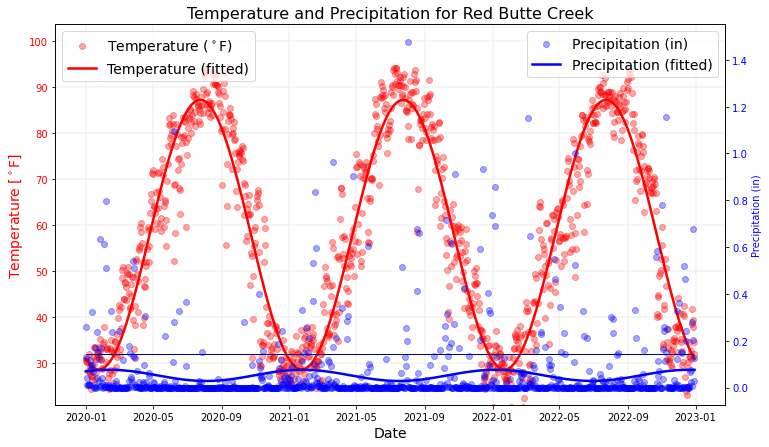

In [55]:

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_t = np.asanyarray(temp_RB['time'].apply(float))  # temperature
x_data_p = np.asanyarray(precip_RB['time'].apply(float))  # precipitation

## Secondly, extract y values (LST) from the dfs.
y_data_t = np.asanyarray(temp_RB['temperature_F'].apply(float))  # temperature
y_data_p = np.asanyarray(precip_RB['precipitation_in'].apply(float))  # precipitation


## For fun, define a fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

#Temperature
params_t, params_covariance_t = optimize.curve_fit(
    fit_func, x_data_t, y_data_t, p0=[lst0, delta_lst, tau, phi])
#Precipitation
params_p, params_covariance_p = optimize.curve_fit(
    fit_func, x_data_p, y_data_p, p0=[lst0, delta_lst, tau, phi])




# Subplots.
fig, ax = plt.subplots(1,1, figsize=(12, 7))
fig.patch.set_facecolor('white')

#set min/max for y-axis, temperature likely will exihibit a greater range than precipitation, thus, it will control the 
#y-axis
ymin = min(temp_RB['temperature_F'])*1.1
ymax = max(temp_RB['temperature_F'])*1.1

#set colors
color_t = 'red'
color_p = 'blue'

#Temperature and Precipitation need their own y-axis

# Add temperature scatter plot.
ax.scatter(temp_RB['datetime'], temp_RB['temperature_F'],
           c=color_t, alpha=0.35, label='Temperature ($^\circ$F)')

# Add temperature fitting curve.
ax.plot(temp_RB['datetime'],
        fit_func(x_data_t, params_t[0], params_t[1], params_t[2], params_t[3]),
        label='Temperature (fitted)', color=color_t, lw=2.5)

# Add some parameters.
ax.set_title('Temperature and Precipitation for Red Butte Creek', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [$^\circ$F]', fontsize=14, color = color_t)
ax.tick_params(axis='y', labelcolor=color_t)
ax.set_ylim(ymin, ymax)

#add freezing pt horizontal line
ax.hlines(y=32, xmin=min(temp_RB['datetime']), xmax=max(temp_RB['datetime']), linewidth=1, color='darkblue')
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper left')

#add a second y-axis to show the precipitation
ax2 = ax.twinx()
ax2.set_ylabel('Precipitation (in)', color=color_p)  # we already handled the x-label with ax1

#add the precipitation scatter plot
ax2.scatter(precip_RB['datetime'], precip_RB['precipitation_in'],
           c=color_p, alpha=0.35, label='Precipitation (in)')

#Add a fitted Precipition line
ax2.plot(precip_RB['datetime'],
        fit_func(x_data_p, params_p[0], params_p[1], params_p[2], params_p[3]),
        label='Precipitation (fitted)', color=color_p, lw=2.5)

ax2.tick_params(axis='y', labelcolor=color_p)
ax2.legend(fontsize=14, loc='upper right')


plt.show()

## Lets Create a DataFrame with all of the information for training a ML model!

We have looked at daily resolution temperature and precipitation, so lets stay at this resolution. 
The NLDAS data is available at 1 hr temporal resolution with the ability to resample to an greater timestep using the [resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) function.

The [Merge, Join, Concatenate and Compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) functions will be most useful here.

In [141]:
#Lets begin with the temperature and precipitation data
Training_DF = temp_RB.copy()

#remote unnecessary columns, time, temperature
colrem = ['time', 'temperature']
Training_DF.drop(colrem, axis =1, inplace =True)

#lets add the precipitation data
Training_DF['precipitation_in'] = precip_RB['precipitation_in']

#set index to datetime
Training_DF.set_index('datetime', drop = True, inplace = True)

#lets add streamflow, but we need to make it at the same temporal resolution (daily)
cols = ['value']
flow = flow[cols]
flow = flow.resample(temporal_resample).mean()
flow.rename(columns ={'value':'flow_cfs'}, inplace = True)

#concat dataframe by date
Training_DF = pd.concat([Training_DF, flow], axis = 1).dropna()

In [142]:
Training_DF

,temperature_F,precipitation_in,flow_cfs
datetime,,,
2020-01-01,30.506,0.260400,1.607283
2020-01-02,30.866,0.128416,1.636875
2020-01-03,30.218,0.040376,1.580729
2020-01-04,30.398,0.011112,1.580000
2020-01-05,28.436,0.008684,1.582188
...,...,...,...
2022-12-26,41.900,0.279984,1.087500
2022-12-27,39.326,0.204304,1.100500
2022-12-28,37.868,0.679064,1.337188
